# Graph Neural Networks (GNN) and how to use them

## Data types

- Sequential data: RNN and Transformers
- Images, video, audio: CNN, MLP, Transformers
- What about graphs? 

## Problems related to graphs

- Graph / Node / Edge  Classification and Regression
- Edge Prediction
- Community Detection
- Learning Graph Embeddings
- Graph Generation
- ...

# Reminder: what is graph and how to process it?

- Graph is $G = (V, E)$, where $V$ is a set of vertices and $E$ is a set of edges
- Representation: adjacency matrix $A = [a_{ij}]$, where $a_{ij} = 1$ if we have an edge from the node $i$ to the node $j$
- Adjacency matrix is typically very large and sparse

# Graph neural networks and deep learning paradigm

- Remember that we start with the concept of representation learning and illustrate this idea in image classifiction problem
- Here the same story but for the graph!
- Our purpose is to develop such functions that will generate
  - nodes represenbtation
  - edges representation
  - entire graph representation
as a vector in a vector space of fixed dimension
- After we get such representations we can solve various problem with different loss functions correspond to a particular problems, e.g. cross-entropy for node classification problem.

## Brief reminder of main ingredients

- Convolution
- Message passing
- Attention

## Convolution

- PyG has [implementations of various versions of convolution operation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers)

- The main idea is to share and filter information for neighbour nodes


In [254]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
! python3 -m pip install torch_geometric -q
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

node_feats = torch.arange(8, 
            dtype=torch.float32).view(4, 2)
adj_matrix = torch.tensor([[1, 1, 0, 0], 
                           [1, 1, 1, 1], 
                           [0, 1, 1, 1], 
                           [0, 1, 1, 1]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.]])

Adjacency matrix:
 tensor([[1, 1, 0, 0],
        [1, 1, 1, 1],
        [0, 1, 1, 1],
        [0, 1, 1, 1]])


### Dummy Convolution

In [230]:
# PyG takes the adjacency matrix as a list of edges
edge_list = torch.concat(torch.where(
    adj_matrix == 1), axis=-1).reshape(2, -1)
print(edge_list)

tensor([[0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [0, 1, 0, 1, 2, 3, 1, 2, 3, 1, 2, 3]])


In [255]:
# Check result of simple convolution with sum aggregation
simple_conv = geom_nn.SimpleConv()
print(simple_conv(node_feats, edge_list))

tensor([[ 2.,  4.],
        [12., 16.],
        [12., 15.],
        [12., 15.]])


In [257]:
print(adj_matrix.float() @ node_feats)

tensor([[ 2.,  4.],
        [12., 16.],
        [12., 15.],
        [12., 15.]])


### GCN convolution
[docs](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv)

In [258]:
gcn = geom_nn.GCNConv(2, 8, bias=False, 
                      normalize=True)
print(gcn(node_feats, edge_list))
-

tensor([[ 0.3723, -1.4965, -1.4036, -0.8653,  0.7523, -0.1361, -0.5825, -0.1124],
        [ 0.8889, -4.9455, -4.7558, -2.3232,  2.1204, -0.8527, -2.4710,  0.0792],
        [ 0.9008, -5.3986, -5.2154, -2.4269,  2.2402, -1.0128, -2.8084,  0.1782],
        [ 0.9008, -5.3986, -5.2154, -2.4269,  2.2402, -1.0128, -2.8084,  0.1782]],
       grad_fn=<ScatterAddBackward0>)
Parameter containing:
tensor([[-0.1523,  0.3075],
        [-0.4295, -0.7643],
        [-0.4919, -0.6765],
        [ 0.1588, -0.6264],
        [-0.0618,  0.5101],
        [-0.3449,  0.0690],
        [-0.5815, -0.1098],
        [ 0.3099, -0.2125]], requires_grad=True)


In [259]:
inv_root_D = torch.diag(1. / torch.sqrt(torch.tensor([2, 4, 3, 3])))
inv_root_D @ adj_matrix.float() @ inv_root_D @ node_feats @ gcn.lin.weight.T

tensor([[ 0.3723, -1.4965, -1.4036, -0.8653,  0.7523, -0.1361, -0.5825, -0.1124],
        [ 0.8889, -4.9455, -4.7558, -2.3232,  2.1204, -0.8527, -2.4710,  0.0792],
        [ 0.9008, -5.3986, -5.2154, -2.4269,  2.2402, -1.0128, -2.8084,  0.1782],
        [ 0.9008, -5.3986, -5.2154, -2.4269,  2.2402, -1.0128, -2.8084,  0.1782]],
       grad_fn=<MmBackward0>)

### ChebNet
[docs](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.ChebConv.html#torch_geometric.nn.conv.ChebConv),
[pdf](https://arxiv.org/pdf/1606.09375.pdf),
[Chebyshev polynomials wiki](https://en.wikipedia.org/wiki/Chebyshev_polynomials)

In [261]:
gcn = geom_nn.ChebConv(2, 8, K=5)
print(gcn(node_feats, edge_list))
gcn.lins

tensor([[ 3.2364,  3.4143, -0.3946, -4.3242, -3.5987,  3.2346, -4.2101, -1.2371],
        [-3.4432, -2.2127, -3.2632, -8.8110, -3.5644,  5.0098,  0.9048,  0.0408],
        [-6.2562, -5.4241, -5.4977, -7.7434,  0.3508,  2.7667,  6.6166,  1.1335],
        [-3.6543, -4.4635, -5.9787, -5.9360,  3.6287,  1.4175,  7.0212, -0.2499]],
       grad_fn=<AddBackward0>)


ModuleList(
  (0): Linear(2, 8, bias=False)
  (1): Linear(2, 8, bias=False)
  (2): Linear(2, 8, bias=False)
  (3): Linear(2, 8, bias=False)
  (4): Linear(2, 8, bias=False)
)

## Check convolutions for node classification

In [263]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora')
print('Number of graphs: {}'.format(len(dataset)))
print('Number of features: {}'.format(dataset.num_features))
print('Number of classes: {}'.format(dataset.num_classes))

data = dataset[0]  # Get the first graph object.
print(data)
print(data.x[0], data.y[0].item())

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([0., 0., 0.,  ..., 0., 0., 0.]) 3


In [265]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color)
    plt.show()

In [266]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(2128506)
        self.conv1 = geom_nn.GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = geom_nn.GCNConv(hidden_channels, dataset.num_classes)
        self.drop = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop(x)
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(hidden_channels=32)
print(gcn_model)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
  (drop): Dropout(p=0.5, inplace=False)
)


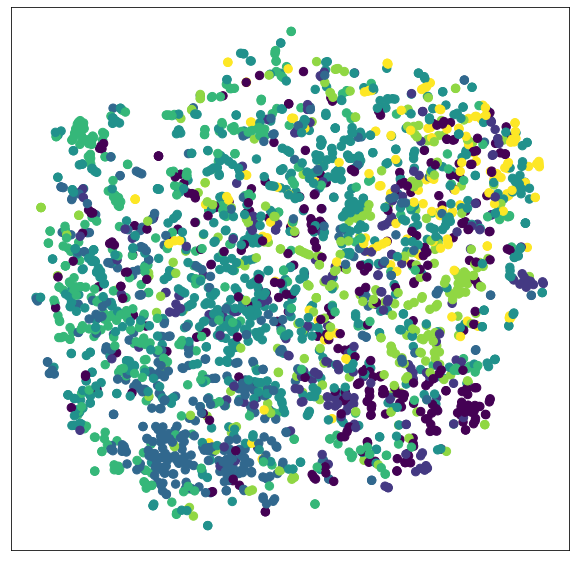

In [267]:
gcn_model.eval()
out = gcn_model(data.x, data.edge_index)
visualize(out, color=data.y)

In [268]:
criterion = torch.nn.CrossEntropyLoss()

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

In [269]:
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
gcn_test_accuracy = []

for epoch in range(1, 21):
    loss = train(gcn_model, data, optimizer)
    gcn_test_accuracy.append(test(gcn_model, data))
    print(f'Epoch: {epoch:},\t Loss: {loss:.4f}')

Epoch: 1,	 Loss: 1.9275
Epoch: 2,	 Loss: 1.7472
Epoch: 3,	 Loss: 1.5225
Epoch: 4,	 Loss: 1.3219
Epoch: 5,	 Loss: 1.1181
Epoch: 6,	 Loss: 0.9258
Epoch: 7,	 Loss: 0.7446
Epoch: 8,	 Loss: 0.6071
Epoch: 9,	 Loss: 0.4898
Epoch: 10,	 Loss: 0.4167
Epoch: 11,	 Loss: 0.3402
Epoch: 12,	 Loss: 0.2981
Epoch: 13,	 Loss: 0.2287
Epoch: 14,	 Loss: 0.1905
Epoch: 15,	 Loss: 0.1524
Epoch: 16,	 Loss: 0.1184
Epoch: 17,	 Loss: 0.1126
Epoch: 18,	 Loss: 0.1082
Epoch: 19,	 Loss: 0.0678
Epoch: 20,	 Loss: 0.0586


In [271]:
test_acc = test(gcn_model, data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7800


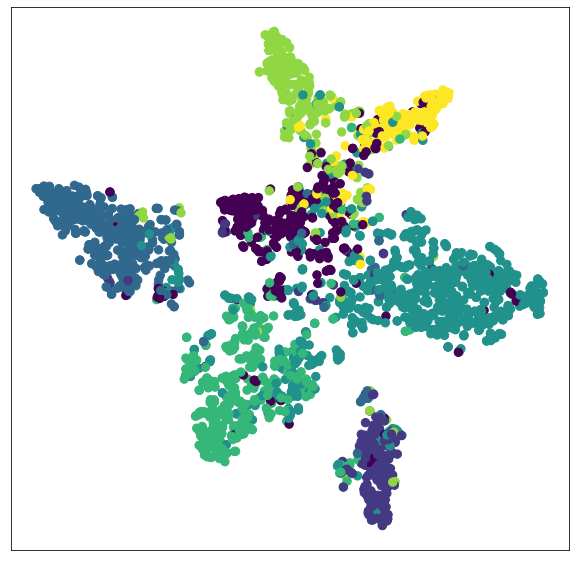

In [272]:
gcn_model.eval()
out = gcn_model(data.x, data.edge_index)
visualize(out, color=data.y)

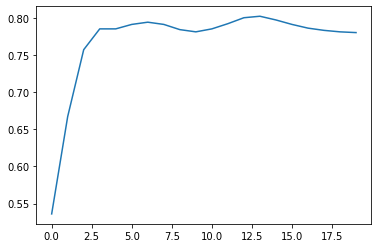

In [273]:
plt.plot(gcn_test_accuracy)

In [245]:
class GChebCN(torch.nn.Module):
    def __init__(self, hidden_channels, K):
        super().__init__()
        torch.manual_seed(2128506)
        self.conv1 = geom_nn.ChebConv(dataset.num_features, hidden_channels, K)
        self.conv2 = geom_nn.ChebConv(hidden_channels, dataset.num_classes, K)
        self.drop = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop(x)
        x = self.conv2(x, edge_index)
        return x

In [274]:
cheb_gcn = GChebCN(32, K=3)
optimizer = torch.optim.Adam(cheb_gcn.parameters(), lr=0.01)
chebcn_test_accuracy = []
for epoch in range(1, 21):
    loss = train(cheb_gcn, data, optimizer)
    chebcn_test_accuracy.append(test(cheb_gcn, data))
    print(f'Epoch: {epoch},\t Loss: {loss:.4f}')

Epoch: 1,	 Loss: 2.0385
Epoch: 2,	 Loss: 1.3648
Epoch: 3,	 Loss: 0.7926
Epoch: 4,	 Loss: 0.4739
Epoch: 5,	 Loss: 0.2473
Epoch: 6,	 Loss: 0.1637
Epoch: 7,	 Loss: 0.0903
Epoch: 8,	 Loss: 0.0440
Epoch: 9,	 Loss: 0.0396
Epoch: 10,	 Loss: 0.0246
Epoch: 11,	 Loss: 0.0341
Epoch: 12,	 Loss: 0.0168
Epoch: 13,	 Loss: 0.0097
Epoch: 14,	 Loss: 0.0062
Epoch: 15,	 Loss: 0.0072
Epoch: 16,	 Loss: 0.0213
Epoch: 17,	 Loss: 0.0035
Epoch: 18,	 Loss: 0.0043
Epoch: 19,	 Loss: 0.0070
Epoch: 20,	 Loss: 0.0008


In [275]:
test_acc = test(cheb_gcn, data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7750


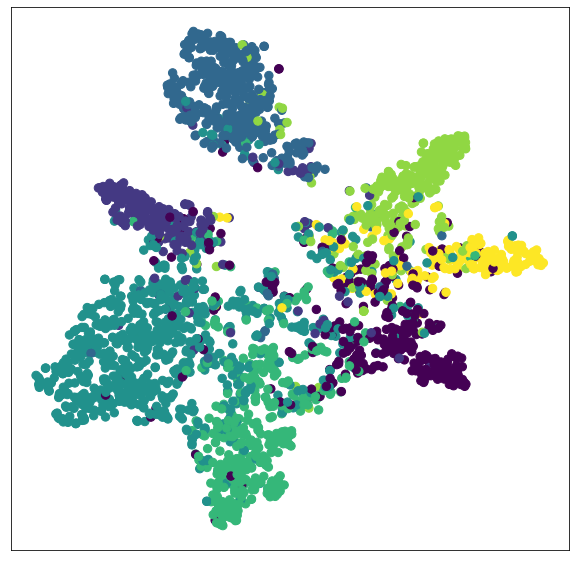

In [276]:
cheb_gcn.eval()
out = cheb_gcn(data.x, data.edge_index)
visualize(out, color=data.y)

Text(0.5, 0, '# epoch')

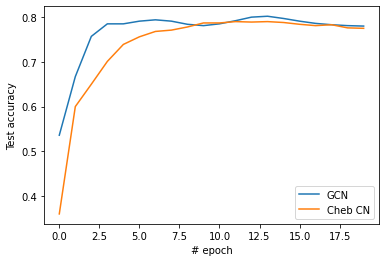

In [277]:
plt.plot(gcn_test_accuracy, label="GCN")
plt.plot(chebcn_test_accuracy, label="Cheb CN")
plt.legend()
plt.ylabel("Test accuracy")
plt.xlabel("# epoch")

## Graph attention
[docs](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)


- We again want to update node representation from the neighbours representations
- For every two nodes we can compute 
$$ e_{ij} = a(Wh_i, Wh_j),$$

where $a$ is some predefined function and $W$ is learnable matrix

- Then we can normalize them only with neighbours with softmax operation

$$ \alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k \in N_i} \exp(e_{ik})} $$

- Now we can update representation $h_i$ as follows

$$ h_i = \sigma\left( \sum_{j \in N_i} \alpha_{ij} W h_j \right) $$

- Example of the function $a$ is simple linear map that reduces concatented input to scalar

$$ a(x, y) = u^\top [x, y],$$

where $u \in \mathbb{R}^{dim(x) + dim(y)}$ is a learnable vector


In [278]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(2128506)
        self.conv1 = geom_nn.GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = geom_nn.GATConv(heads * hidden_channels, dataset.num_classes,heads)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.drop(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.drop(x)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=32, heads=8)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
gat_test_accuracy = []
for epoch in range(1, 21):
    loss = train(model, data, optimizer)
    gat_test_accuracy.append(test(model, data))
    print(f'Epoch: {epoch:},\t Loss: {loss:.4f}')

GAT(
  (conv1): GATConv(1433, 32, heads=8)
  (conv2): GATConv(256, 7, heads=8)
  (drop): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)
Epoch: 1,	 Loss: 3.9761
Epoch: 2,	 Loss: 3.0069
Epoch: 3,	 Loss: 1.8436
Epoch: 4,	 Loss: 1.0772
Epoch: 5,	 Loss: 0.6553
Epoch: 6,	 Loss: 0.4706
Epoch: 7,	 Loss: 0.2994
Epoch: 8,	 Loss: 0.2233
Epoch: 9,	 Loss: 0.1750
Epoch: 10,	 Loss: 0.1970
Epoch: 11,	 Loss: 0.1165
Epoch: 12,	 Loss: 0.1241
Epoch: 13,	 Loss: 0.0932
Epoch: 14,	 Loss: 0.1476
Epoch: 15,	 Loss: 0.1312
Epoch: 16,	 Loss: 0.1232
Epoch: 17,	 Loss: 0.0600
Epoch: 18,	 Loss: 0.1695
Epoch: 19,	 Loss: 0.1520
Epoch: 20,	 Loss: 0.0580


In [251]:
test_acc = test(model, data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7200


Text(0.5, 0, '# epoch')

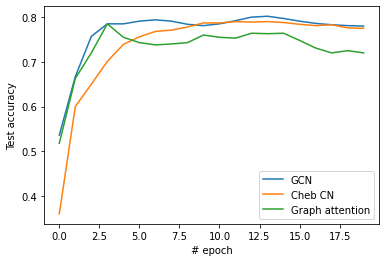

In [279]:
plt.plot(gcn_test_accuracy, label="GCN")
plt.plot(chebcn_test_accuracy, label="Cheb CN")
plt.plot(gat_test_accuracy, label="Graph attention")
plt.legend()
plt.ylabel("Test accuracy")
plt.xlabel("# epoch")

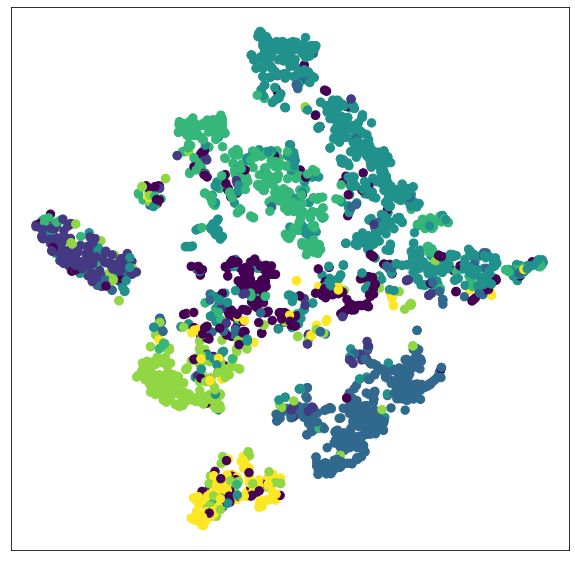

In [280]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### What about the Edge Convolution?
[docs](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html#implementing-the-edge-convolution)

$$
\mathbf{x}_i^{(k)} = \max_{j \in \mathcal{N}(i)} h_{\mathbf{\Theta}} \left( \texttt{concat}\left( \mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)} - \mathbf{x}_i^{(k-1)}\right) \right),
$$
where $\mathbf{x}_i$ are edge embeddings and $h_{\mathbf{\Theta}}$ is an MLP.


### Open questions

- How can we effectively sample graphs for training graph neural networks?
- How to train deep graph neural networks? 
- How not to overfit?

# Summary

- GNN is a useful tool for graph processing
- Various configurations of simple operations are possible
- Scalability and robustness is challenging

![](GNN.jpg)